<a href="https://colab.research.google.com/github/leah108/Analysis_bio/blob/main/Prediction_on_Hospital_Readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##1. 데이터 전처리

In [4]:
#loading dataset
df = pd.read_csv("/content/drive/MyDrive/first/diabetic_data.csv")
df.head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
#checking shape of the dataset
df.shape

(101766, 50)

In [6]:
#Checking data types of each variable
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

1-1. 결측치 확인

In [7]:
#Checking for missing values in dataset
#In the dataset missing values are represented as '?' sign

for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

race 2273
gender 0
age 0
weight 98569
payer_code 40256
medical_specialty 49949
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
examide 0
citoglipton 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0


In [8]:
# gender는 결측치가 다르게 표시 -> 따로 개수 구함

print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

gender 3


1-2. 결측치 처리

In [9]:
# 결측치 많은 column 지우기 (weight : 대략 98%, payer_code/medical_specialty : 대략 40%)

df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)

In [10]:
# drop_Idx에 값이 ?인 것을 다 넣어서 인덱스 만들기 -> 원래 인덱스에서 drop_Index 빼주기
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['race'][df['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

In [11]:
# 약 이름인 citogliption, examide는 모든 행이 같은 값을 가져서 예측에 필요 없음

df = df.drop(['citoglipton', 'examide'], axis = 1)

In [12]:
#Checking for missing values in the data

for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())

print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count())

race 0
gender 0
age 0
diag_1 0
diag_2 0
diag_3 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 0


1-3. 변수 조작

In [13]:
# number_outpatient와 number_emergency와 number_inpatient를 합쳐서 새로운 변수로 만듦 (간단하게 보이기 위해 판단)

df['service_utilization'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']

In [14]:
# 23가지 약물 이름이 있고 해당 약물이 변경되었는 여부를 나타내고 입원 시 당뇨병 환자에 대한 약물 변경은 이전 연구에서 재입원률 감소와 관련이 있는 것으로 나타남 -> 총 몇 번의 변경이 이루어졌는지 세어보기

keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in keys:
    colname = str(col) + 'temp'
    df[colname] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

df['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    df['numchange'] = df['numchange'] + df[colname]
    del df[colname]

df['numchange'].value_counts()

0    70142
1    24922
2     1271
3      106
4        5
Name: numchange, dtype: int64

In [15]:
df['discharge_disposition_id']

1         1
2         1
3         1
4         1
5         1
         ..
101761    3
101762    4
101763    1
101764    3
101765    1
Name: discharge_disposition_id, Length: 96446, dtype: int64

In [16]:
# 입원유형, 퇴원유형, 입원 원인을 더 작은 카테고리로 만들기
# 데이터셋 이해해야 replace한 값들 이해 가능할 듯

df['admission_type_id'] = df['admission_type_id'].replace(2,1)
df['admission_type_id'] = df['admission_type_id'].replace(7,1)
df['admission_type_id'] = df['admission_type_id'].replace(6,5)
df['admission_type_id'] = df['admission_type_id'].replace(8,5)

df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(8,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(13,1)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(3,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(14,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24,2)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(12,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(16,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(17,10)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25,18)
df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(26,18)

df['admission_source_id'] = df['admission_source_id'].replace(2,1)
df['admission_source_id'] = df['admission_source_id'].replace(3,1)
df['admission_source_id'] = df['admission_source_id'].replace(5,4)
df['admission_source_id'] = df['admission_source_id'].replace(6,4)
df['admission_source_id'] = df['admission_source_id'].replace(10,4)
df['admission_source_id'] = df['admission_source_id'].replace(22,4)
df['admission_source_id'] = df['admission_source_id'].replace(25,4)
df['admission_source_id'] = df['admission_source_id'].replace(15,9)
df['admission_source_id'] = df['admission_source_id'].replace(17,9)
df['admission_source_id'] = df['admission_source_id'].replace(20,9)
df['admission_source_id'] = df['admission_source_id'].replace(21,9)
df['admission_source_id'] = df['admission_source_id'].replace(13,11)
df['admission_source_id'] = df['admission_source_id'].replace(14,11)

In [17]:
# 이진변수로 만들기 (change : Ch->1, N0 -> 0), (gender : Male -> 1, Female ->0), (do)

df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

# keys is the same as before
#**
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)

In [18]:
# 범주형으로 만들기 (A1Cresult : >7, >8 -> 1, Norm -> 0, None -> -99), (max_glu_serum : >200, >300 -> 1, Norm -> 0, None -> -99)
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

In [19]:
# age가 범주로 되어 있음(ex:10-20) -> 중앙값으로 다 바꿈(ex:15)
# code age intervals [0-10) - [90-100) from 1-10

for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age'].value_counts()

8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: age, dtype: int64

In [20]:
# drop_duplicates는 중복행 제거
# 환자의 첫 방문만 사용

df2 = df.drop_duplicates(subset= ['patient_nbr'], keep = 'first')
df2.shape

(67580, 47)

In [21]:
df.head().T

,1,2,3,4,5
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,1,1,1
age,2,3,4,5,6
admission_type_id,1,1,1,1,1
discharge_disposition_id,1,1,1,1,1
admission_source_id,7,7,7,7,1
time_in_hospital,3,2,2,1,3
num_lab_procedures,59,11,44,51,31


In [22]:
# 우리가 필요한건 30일 이내 재입원 -> 30일 이후 재입원과 재입원 없음을 하나의 범주로
df['readmitted'].value_counts()

NO     50731
>30    34649
<30    11066
Name: readmitted, dtype: int64

In [23]:
df['readmitted'] = df['readmitted'].replace('>30', 0)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

In [24]:
# 1, 2, 3차 진단이 있고 많은 질병을 비슷한 것끼리 9가지 범주로 나눔 그리고 1차 진단만 사용
# Creating additional columns for diagnosis

df['level1_diag1'] = df['diag_1']
df['level2_diag1'] = df['diag_1']
df['level1_diag2'] = df['diag_2']
df['level2_diag2'] = df['diag_2']
df['level1_diag3'] = df['diag_3']
df['level2_diag3'] = df['diag_3']

*?의문점

왜 값에 문자가 있는지, 왜 'E','V'가 들어간 값을 바꾸는지 : E-V -> External causes of injury and supplemental classification(부상의 외부 원인 및 보충 분류)

왜 ?가 있는지 :

In [25]:
df.loc[df['diag_1'].str.contains('V')]  # 왜 값에 문자가 있는지, 왜 'E','V'가 들어간 값을 바꾸는지, 왜 0으로 바꾸는지, 왜 ?가 있는지

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,diabetesMed,readmitted,service_utilization,numchange,level1_diag1,level2_diag1,level1_diag2,level2_diag2,level1_diag3,level2_diag3
23,183930,107400762,Caucasian,0,9,1,1,1,11,42,...,0,0,0,0,V57,V57,715,715,V43,V43
42,421194,96435585,Caucasian,0,8,1,1,1,13,48,...,1,0,1,0,V57,V57,276,276,781,781
253,2926554,86209290,Caucasian,0,8,5,1,1,7,37,...,1,0,1,1,V57,V57,157,157,250.02,250.02
290,3086520,95564241,Caucasian,0,7,5,1,1,8,35,...,1,0,1,0,V57,V57,153,153,250.02,250.02
316,3187926,476343,AfricanAmerican,0,7,5,18,1,4,54,...,0,0,0,0,V55,V55,998,998,401,401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101081,434871134,52126479,Caucasian,0,10,5,1,1,7,29,...,0,0,2,0,V57,V57,781,781,486,486
101127,435465620,41596461,Caucasian,0,10,3,1,1,1,44,...,0,0,1,0,V53,V53,414,414,424,424
101185,436104914,114613173,Caucasian,0,7,3,1,1,9,43,...,1,0,2,1,V57,V57,174,174,V45,V45
101265,437253248,147593579,Caucasian,0,8,3,1,4,8,1,...,1,1,1,1,V57,V57,434,434,V43,V43


In [26]:
df.loc[df['diag_1'].str.contains('V'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_1'].str.contains('E'), ['level1_diag1', 'level2_diag1']] = 0
df.loc[df['diag_2'].str.contains('V'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_2'].str.contains('E'), ['level1_diag2', 'level2_diag2']] = 0
df.loc[df['diag_3'].str.contains('V'), ['level1_diag3', 'level2_diag3']] = 0
df.loc[df['diag_3'].str.contains('E'), ['level1_diag3', 'level2_diag3']] = 0
df['level1_diag1'] = df['level1_diag1'].replace('?', -1)
df['level2_diag1'] = df['level2_diag1'].replace('?', -1)
df['level1_diag2'] = df['level1_diag2'].replace('?', -1)
df['level2_diag2'] = df['level2_diag2'].replace('?', -1)
df['level1_diag3'] = df['level1_diag3'].replace('?', -1)
df['level2_diag3'] = df['level2_diag3'].replace('?', -1)

In [27]:
df['level1_diag1'] = df['level1_diag1'].astype(float)
df['level2_diag1'] = df['level2_diag1'].astype(float)
df['level1_diag2'] = df['level1_diag2'].astype(float)
df['level2_diag2'] = df['level2_diag2'].astype(float)
df['level1_diag3'] = df['level1_diag3'].astype(float)
df['level2_diag3'] = df['level2_diag3'].astype(float)

In [28]:
for index, row in df.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        df.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        df.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        df.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        df.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        df.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        df.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        df.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        df.loc[index, 'level1_diag1'] = 8
    else:
        df.loc[index, 'level1_diag1'] = 0

    if (row['level1_diag2'] >= 390 and row['level1_diag2'] < 460) or (np.floor(row['level1_diag2']) == 785):
        df.loc[index, 'level1_diag2'] = 1
    elif (row['level1_diag2'] >= 460 and row['level1_diag2'] < 520) or (np.floor(row['level1_diag2']) == 786):
        df.loc[index, 'level1_diag2'] = 2
    elif (row['level1_diag2'] >= 520 and row['level1_diag2'] < 580) or (np.floor(row['level1_diag2']) == 787):
        df.loc[index, 'level1_diag2'] = 3
    elif (np.floor(row['level1_diag2']) == 250):
        df.loc[index, 'level1_diag2'] = 4
    elif (row['level1_diag2'] >= 800 and row['level1_diag2'] < 1000):
        df.loc[index, 'level1_diag2'] = 5
    elif (row['level1_diag2'] >= 710 and row['level1_diag2'] < 740):
        df.loc[index, 'level1_diag2'] = 6
    elif (row['level1_diag2'] >= 580 and row['level1_diag2'] < 630) or (np.floor(row['level1_diag2']) == 788):
        df.loc[index, 'level1_diag2'] = 7
    elif (row['level1_diag2'] >= 140 and row['level1_diag2'] < 240):
        df.loc[index, 'level1_diag2'] = 8
    else:
        df.loc[index, 'level1_diag2'] = 0

    if (row['level1_diag3'] >= 390 and row['level1_diag3'] < 460) or (np.floor(row['level1_diag3']) == 785):
        df.loc[index, 'level1_diag3'] = 1
    elif (row['level1_diag3'] >= 460 and row['level1_diag3'] < 520) or (np.floor(row['level1_diag3']) == 786):
        df.loc[index, 'level1_diag3'] = 2
    elif (row['level1_diag3'] >= 520 and row['level1_diag3'] < 580) or (np.floor(row['level1_diag3']) == 787):
        df.loc[index, 'level1_diag3'] = 3
    elif (np.floor(row['level1_diag3']) == 250):
        df.loc[index, 'level1_diag3'] = 4
    elif (row['level1_diag3'] >= 800 and row['level1_diag3'] < 1000):
        df.loc[index, 'level1_diag3'] = 5
    elif (row['level1_diag3'] >= 710 and row['level1_diag3'] < 740):
        df.loc[index, 'level1_diag3'] = 6
    elif (row['level1_diag3'] >= 580 and row['level1_diag3'] < 630) or (np.floor(row['level1_diag3']) == 788):
        df.loc[index, 'level1_diag3'] = 7
    elif (row['level1_diag3'] >= 140 and row['level1_diag3'] < 240):
        df.loc[index, 'level1_diag3'] = 8
    else:
        df.loc[index, 'level1_diag3'] = 0

In [29]:
for index, row in df.iterrows():
    if (row['level2_diag1'] >= 390 and row['level2_diag1'] < 399):
        df.loc[index, 'level2_diag1'] = 1
    elif (row['level2_diag1'] >= 401 and row['level2_diag1'] < 415):
        df.loc[index, 'level2_diag1'] = 2
    elif (row['level2_diag1'] >= 415 and row['level2_diag1'] < 460):
        df.loc[index, 'level2_diag1'] = 3
    elif (np.floor(row['level2_diag1']) == 785):
        df.loc[index, 'level2_diag1'] = 4
    elif (row['level2_diag1'] >= 460 and row['level2_diag1'] < 489):
        df.loc[index, 'level2_diag1'] = 5
    elif (row['level2_diag1'] >= 490 and row['level2_diag1'] < 497):
        df.loc[index, 'level2_diag1'] = 6
    elif (row['level2_diag1'] >= 500 and row['level2_diag1'] < 520):
        df.loc[index, 'level2_diag1'] = 7
    elif (np.floor(row['level2_diag1']) == 786):
        df.loc[index, 'level2_diag1'] = 8
    elif (row['level2_diag1'] >= 520 and row['level2_diag1'] < 530):
        df.loc[index, 'level2_diag1'] = 9
    elif (row['level2_diag1'] >= 530 and row['level2_diag1'] < 544):
        df.loc[index, 'level2_diag1'] = 10
    elif (row['level2_diag1'] >= 550 and row['level2_diag1'] < 554):
        df.loc[index, 'level2_diag1'] = 11
    elif (row['level2_diag1'] >= 555 and row['level2_diag1'] < 580):
        df.loc[index, 'level2_diag1'] = 12
    elif (np.floor(row['level2_diag1']) == 787):
        df.loc[index, 'level2_diag1'] = 13
    elif (np.floor(row['level2_diag1']) == 250):
        df.loc[index, 'level2_diag1'] = 14
    elif (row['level2_diag1'] >= 800 and row['level2_diag1'] < 1000):
        df.loc[index, 'level2_diag1'] = 15
    elif (row['level2_diag1'] >= 710 and row['level2_diag1'] < 740):
        df.loc[index, 'level2_diag1'] = 16
    elif (row['level2_diag1'] >= 580 and row['level2_diag1'] < 630):
        df.loc[index, 'level2_diag1'] = 17
    elif (np.floor(row['level2_diag1']) == 788):
        df.loc[index, 'level2_diag1'] = 18
    elif (row['level2_diag1'] >= 140 and row['level2_diag1'] < 240):
        df.loc[index, 'level2_diag1'] = 19
    elif row['level2_diag1'] >= 240 and row['level2_diag1'] < 280 and (np.floor(row['level2_diag1']) != 250):
        df.loc[index, 'level2_diag1'] = 20
    elif (row['level2_diag1'] >= 680 and row['level2_diag1'] < 710) or (np.floor(row['level2_diag1']) == 782):
        df.loc[index, 'level2_diag1'] = 21
    elif (row['level2_diag1'] >= 290 and row['level2_diag1'] < 320):
        df.loc[index, 'level2_diag1'] = 22
    else:
        df.loc[index, 'level2_diag1'] = 0

    if (row['level2_diag2'] >= 390 and row['level2_diag2'] < 399):
        df.loc[index, 'level2_diag2'] = 1
    elif (row['level2_diag2'] >= 401 and row['level2_diag2'] < 415):
        df.loc[index, 'level2_diag2'] = 2
    elif (row['level2_diag2'] >= 415 and row['level2_diag2'] < 460):
        df.loc[index, 'level2_diag2'] = 3
    elif (np.floor(row['level2_diag2']) == 785):
        df.loc[index, 'level2_diag2'] = 4
    elif (row['level2_diag2'] >= 460 and row['level2_diag2'] < 489):
        df.loc[index, 'level2_diag2'] = 5
    elif (row['level2_diag2'] >= 490 and row['level2_diag2'] < 497):
        df.loc[index, 'level2_diag2'] = 6
    elif (row['level2_diag2'] >= 500 and row['level2_diag2'] < 520):
        df.loc[index, 'level2_diag2'] = 7
    elif (np.floor(row['level2_diag2']) == 786):
        df.loc[index, 'level2_diag2'] = 8
    elif (row['level2_diag2'] >= 520 and row['level2_diag2'] < 530):
        df.loc[index, 'level2_diag2'] = 9
    elif (row['level2_diag2'] >= 530 and row['level2_diag2'] < 544):
        df.loc[index, 'level2_diag2'] = 10
    elif (row['level2_diag2'] >= 550 and row['level2_diag2'] < 554):
        df.loc[index, 'level2_diag2'] = 11
    elif (row['level2_diag2'] >= 555 and row['level2_diag2'] < 580):
        df.loc[index, 'level2_diag2'] = 12
    elif (np.floor(row['level2_diag2']) == 787):
        df.loc[index, 'level2_diag2'] = 13
    elif (np.floor(row['level2_diag2']) == 250):
        df.loc[index, 'level2_diag2'] = 14
    elif (row['level2_diag2'] >= 800 and row['level2_diag2'] < 1000):
        df.loc[index, 'level2_diag2'] = 15
    elif (row['level2_diag2'] >= 710 and row['level2_diag2'] < 740):
        df.loc[index, 'level2_diag2'] = 16
    elif (row['level2_diag2'] >= 580 and row['level2_diag2'] < 630):
        df.loc[index, 'level2_diag2'] = 17
    elif (np.floor(row['level2_diag2']) == 788):
        df.loc[index, 'level2_diag2'] = 18
    elif (row['level2_diag2'] >= 140 and row['level2_diag2'] < 240):
        df.loc[index, 'level2_diag2'] = 19
    elif row['level2_diag2'] >= 240 and row['level2_diag2'] < 280 and (np.floor(row['level2_diag2']) != 250):
        df.loc[index, 'level2_diag2'] = 20
    elif (row['level2_diag2'] >= 680 and row['level2_diag2'] < 710) or (np.floor(row['level2_diag2']) == 782):
        df.loc[index, 'level2_diag2'] = 21
    elif (row['level2_diag2'] >= 290 and row['level2_diag2'] < 320):
        df.loc[index, 'level2_diag2'] = 22
    else:
        df.loc[index, 'level2_diag2'] = 0


    if (row['level2_diag3'] >= 390 and row['level2_diag3'] < 399):
        df.loc[index, 'level2_diag3'] = 1
    elif (row['level2_diag3'] >= 401 and row['level2_diag3'] < 415):
        df.loc[index, 'level2_diag3'] = 2
    elif (row['level2_diag3'] >= 415 and row['level2_diag3'] < 460):
        df.loc[index, 'level2_diag3'] = 3
    elif (np.floor(row['level2_diag3']) == 785):
        df.loc[index, 'level2_diag3'] = 4
    elif (row['level2_diag3'] >= 460 and row['level2_diag3'] < 489):
        df.loc[index, 'level2_diag3'] = 5
    elif (row['level2_diag3'] >= 490 and row['level2_diag3'] < 497):
        df.loc[index, 'level2_diag3'] = 6
    elif (row['level2_diag3'] >= 500 and row['level2_diag3'] < 520):
        df.loc[index, 'level2_diag3'] = 7
    elif (np.floor(row['level2_diag3']) == 786):
        df.loc[index, 'level2_diag3'] = 8
    elif (row['level2_diag3'] >= 520 and row['level2_diag3'] < 530):
        df.loc[index, 'level2_diag3'] = 9
    elif (row['level2_diag3'] >= 530 and row['level2_diag3'] < 544):
        df.loc[index, 'level2_diag3'] = 10
    elif (row['level2_diag3'] >= 550 and row['level2_diag3'] < 554):
        df.loc[index, 'level2_diag3'] = 11
    elif (row['level2_diag3'] >= 555 and row['level2_diag3'] < 580):
        df.loc[index, 'level2_diag3'] = 12
    elif (np.floor(row['level2_diag3']) == 787):
        df.loc[index, 'level2_diag3'] = 13
    elif (np.floor(row['level2_diag3']) == 250):
        df.loc[index, 'level2_diag3'] = 14
    elif (row['level2_diag3'] >= 800 and row['level2_diag3'] < 1000):
        df.loc[index, 'level2_diag3'] = 15
    elif (row['level2_diag3'] >= 710 and row['level2_diag3'] < 740):
        df.loc[index, 'level2_diag3'] = 16
    elif (row['level2_diag3'] >= 580 and row['level2_diag3'] < 630):
        df.loc[index, 'level2_diag3'] = 17
    elif (np.floor(row['level2_diag3']) == 788):
        df.loc[index, 'level2_diag3'] = 18
    elif (row['level2_diag3'] >= 140 and row['level2_diag3'] < 240):
        df.loc[index, 'level2_diag3'] = 19
    elif row['level2_diag3'] >= 240 and row['level2_diag3'] < 280 and (np.floor(row['level2_diag3']) != 250):
        df.loc[index, 'level2_diag3'] = 20
    elif (row['level2_diag3'] >= 680 and row['level2_diag3'] < 710) or (np.floor(row['level2_diag3']) == 782):
        df.loc[index, 'level2_diag3'] = 21
    elif (row['level2_diag3'] >= 290 and row['level2_diag3'] < 320):
        df.loc[index, 'level2_diag3'] = 22
    else:
        df.loc[index, 'level2_diag3'] = 0

## 2. 데이터 시각화

Text(0.5, 1.0, 'Distrinution of Readmission')

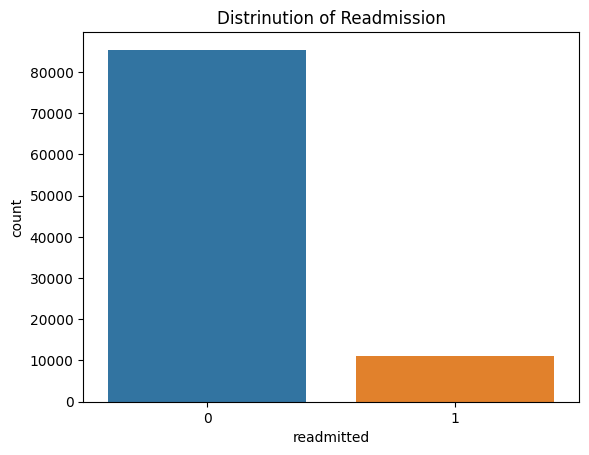

In [53]:
# Distribution of Readmission
# countplot : 해당 칼럼의 데이터 개수를 막대그래프로 나타냄
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x = df['readmitted']).set_title('Distrinution of Readmission')


<ipython-input-54-6fcba69681df>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df.loc[(df['readmitted'] == 0), 'time_in_hospital'], color='b', shade=True, label='Not Readmitted')
<ipython-input-54-6fcba69681df>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(df.loc[(df['readmitted'] == 1), 'time_in_hospital'], color='r', shade=True, label='Readmitted')


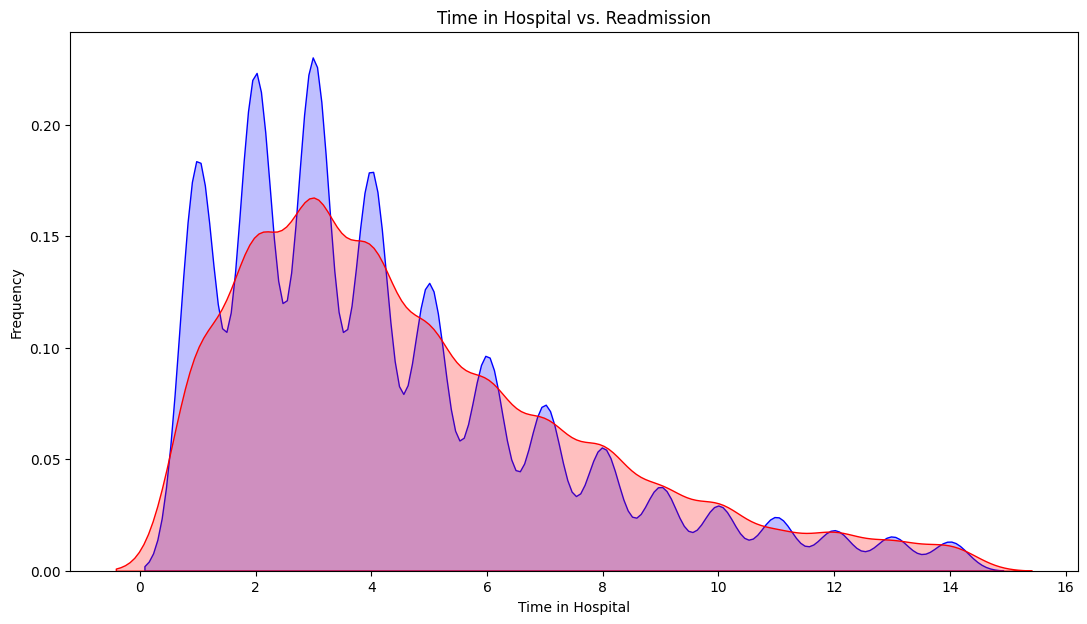

In [54]:
# Time in Hospital and Readmission

fig = plt.figure(figsize=(13, 7))
ax = sns.kdeplot(df.loc[(df['readmitted'] == 0), 'time_in_hospital'], color='b', shade=True, label='Not Readmitted')
ax = sns.kdeplot(df.loc[(df['readmitted'] == 1), 'time_in_hospital'], color='r', shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital vs. Readmission')
plt.show()


Text(0.5, 1.0, 'Age of Patient VS. Readmission')

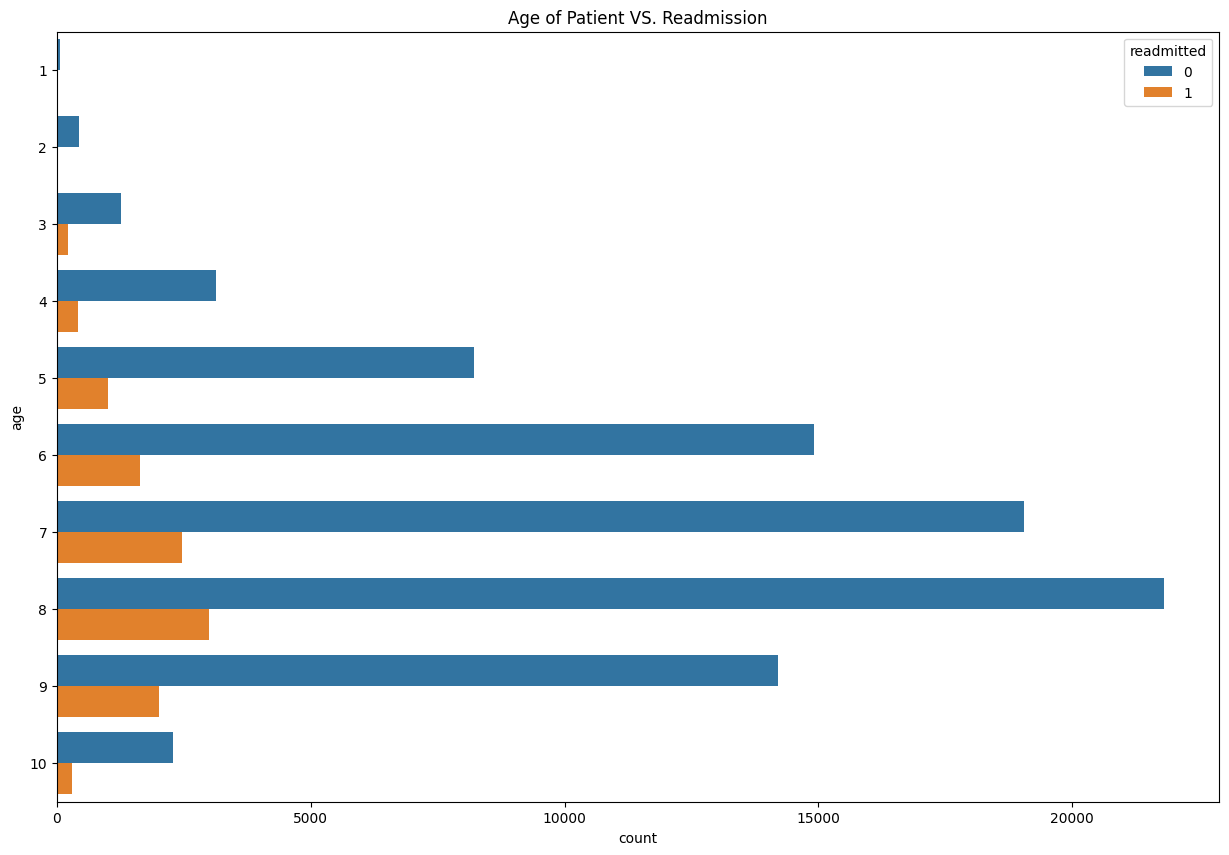

In [44]:
# Age and Readmission

fig = plt.figure(figsize=(15,10))
sns.countplot(y= df['age'], hue = df['readmitted']).set_title('Age of Patient VS. Readmission')

<Axes: xlabel='count', ylabel='race'>

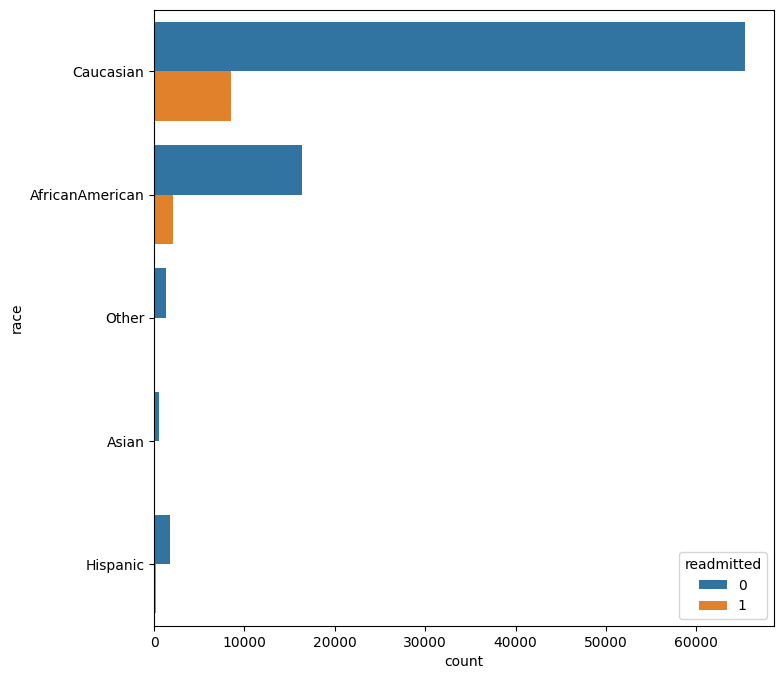

In [55]:
# Ethnicity of patient and Readmission

fig = plt.figure(figsize=(8,8))
sns.countplot(y = df['race'], hue = df['readmitted'])

Text(0.5, 1.0, 'Number of medication used VS. Readmission')

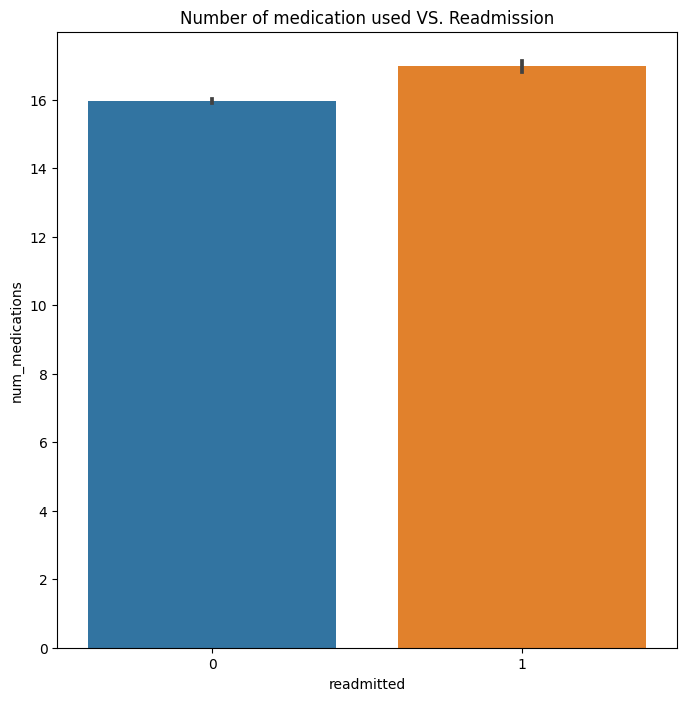

In [56]:
# Number of medication used and Readmission

fig = plt.figure(figsize=(8,8))
sns.barplot(x = df['readmitted'], y = df['num_medications']).set_title("Number of medication used VS. Readmission")

Text(0.5, 1.0, 'Gender of Patient VS. Readmission')

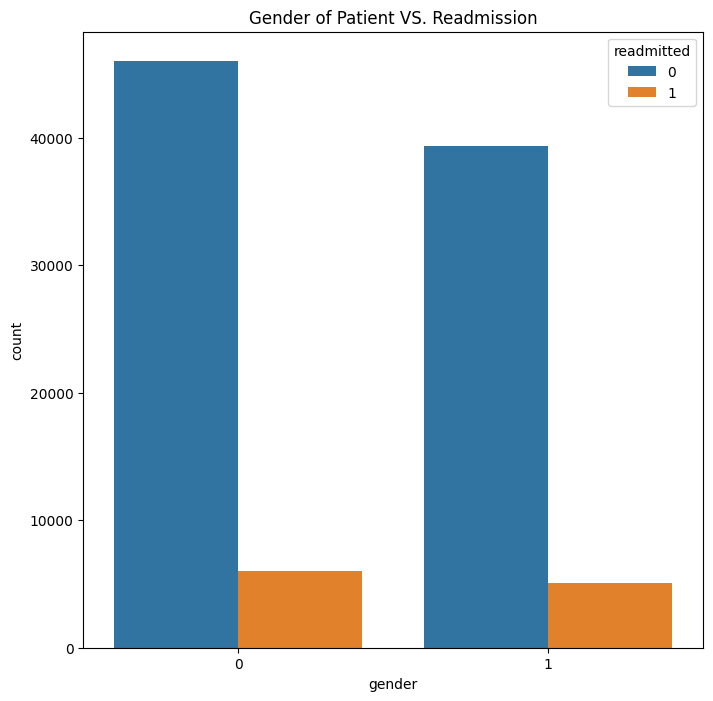

In [57]:
# Gender and Readmission
# Male = 1/ Female = 0

fig = plt.figure(figsize=(8,8))
sns.countplot(x = df['gender'], hue = df['readmitted']).set_title("Gender of Patient VS. Readmission")

Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

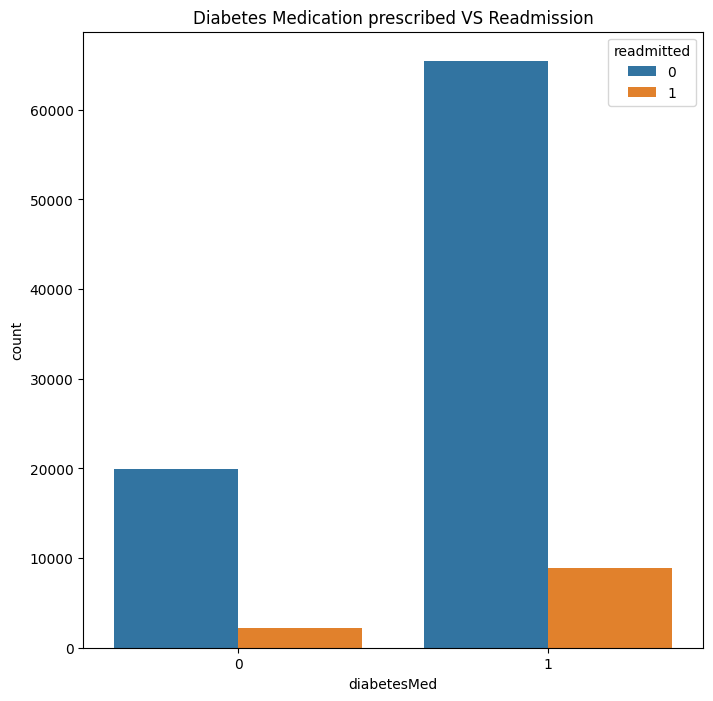

In [59]:
# Diabetes Medication prescribed and Readmission
# Values: “yes” : 1 “no” : 0

fig = plt.figure(figsize=(8,8))
sns.countplot(x = df['diabetesMed'], hue = df['readmitted']).set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'Service Utilization VS. Readmission')

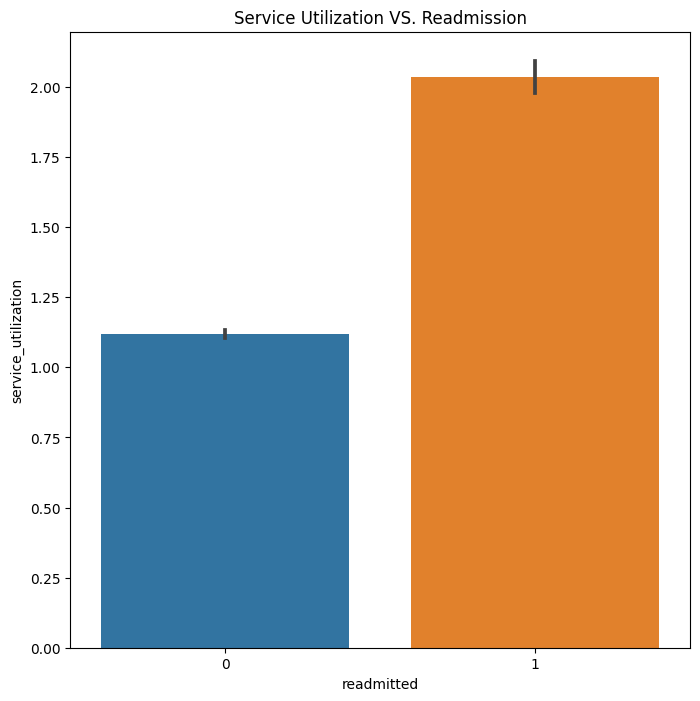

In [60]:
# Service Utilization and Readmission

fig = plt.figure(figsize=(8,8))
sns.barplot( y = df['service_utilization'], x = df['readmitted']).set_title('Service Utilization VS. Readmission')

Text(0.5, 1.0, 'Glucose test serum test result VS. Readmission')

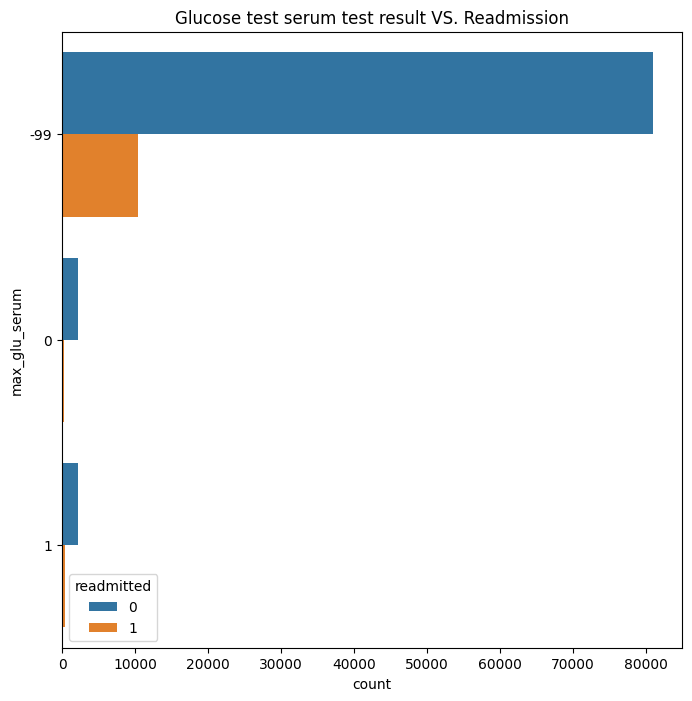

In [61]:
# Glucose serum test result and Readmission
# '>200' : 1 = indicates diabetes
# '>300' : 1 = Indicates diabetes
# 'Norm' : 0 = Normal
# 'None' : -99 = test was not taken

fig = plt.figure(figsize=(8,8))
sns.countplot(y = df['max_glu_serum'], hue = df['readmitted']).set_title('Glucose test serum test result VS. Readmission')


Text(0.5, 1.0, 'A1C test result VS. Readmission')

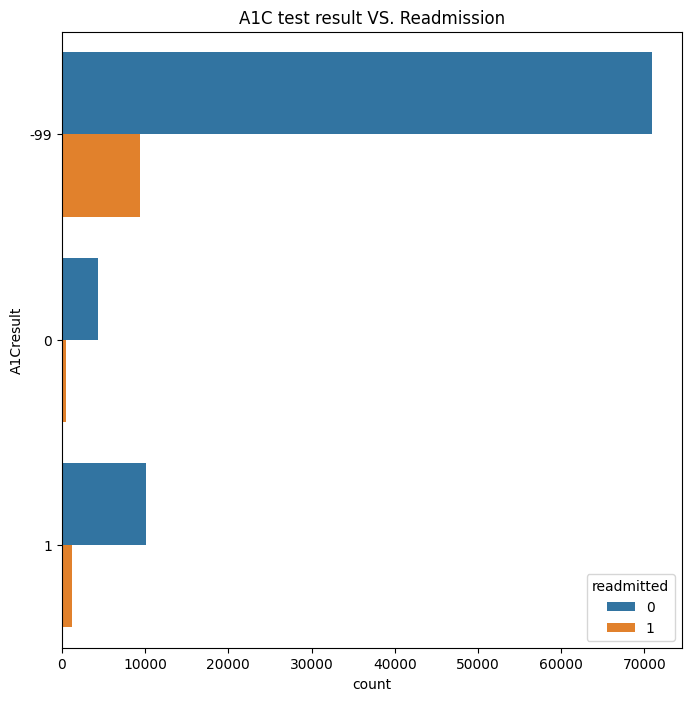

In [62]:
# A1C result and Readmission A1C test - The A1C test is a blood test that provides information about your average levels of blood glucose, also called blood sugar, over the past 3 months.
# '>7' : 1
# '>8' : 1
# Norm : 0 = Normal
# None : -99 = Test was not taken

fig = plt.figure(figsize=(8,8))
sns.countplot(y= df['A1Cresult'], hue = df['readmitted']).set_title('A1C test result VS. Readmission')

<ipython-input-63-96319f180755>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
<ipython-input-63-96319f180755>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')


Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

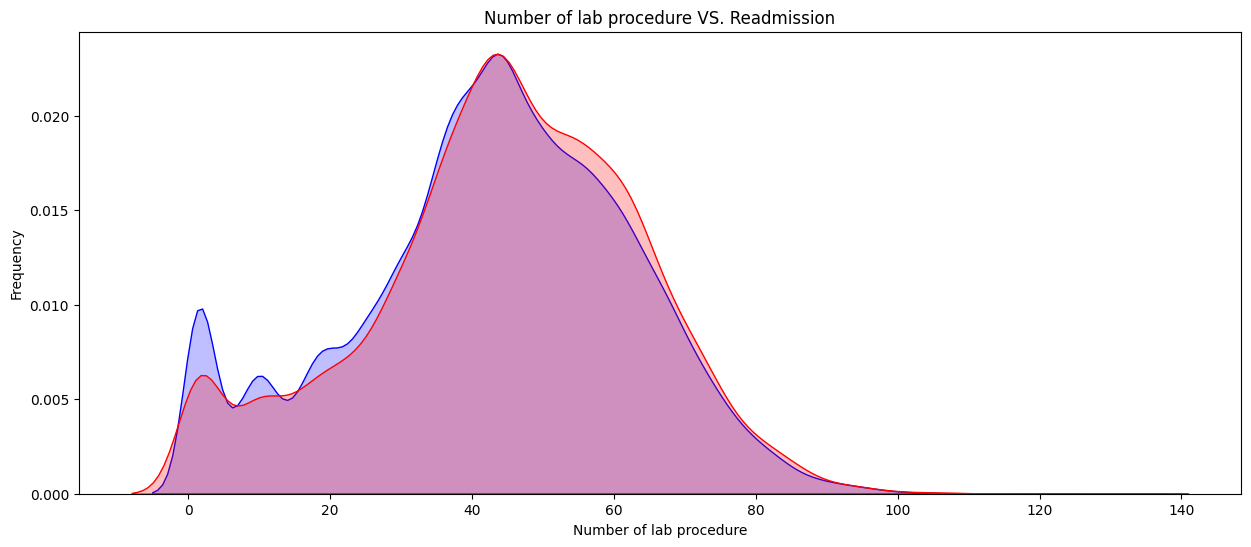

In [63]:
# Number of lab procedure and Readmission¶

fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(df.loc[(df['readmitted'] == 0),'num_lab_procedures'] , color='b',shade=True,label='Not readmitted')
ax=sns.kdeplot(df.loc[(df['readmitted'] == 1),'num_lab_procedures'] , color='r',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

## 3. Pre-Modeling Data Preprocessing

## 4. Modeling

#### Logistic Regression

#### Decision Tree

#### Random Forest

## 5. 모델 비교